Import the necessary libaries

In [26]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics
import os
from collections import Counter
from compute_openmax import compute_mean_activation_vector

## Classification Report

Load the openmax score from cache and save it in `y_pred_ours`. These are simply the logits of the 10000 test images + 10000 outlying images extended by the outlying probability, i.e., a list of 20000 vectors of shape (11,). These can be reproduced py calling the script `python compute_openmax.py --save_openmax_scores`.

`y_true` are the ground truth scores: The first 10000 scores belong to the test-images, which are in order, i.e., the first 10000 are of class 0, the next 10000 of class 1 and so on. The last 100000 outlying images are of class 10.

In [32]:
with open(os.path.join('data', 'plot_pickles', 'openmax_scores_maxpool_100_softmax_before.pickle'), 'rb') as f:
    openmax_scores = pickle.load(f)

y_true = np.concatenate((np.repeat(np.arange(10), 1000), np.repeat(10, 10000))) 

First, we print the scores only for the test images. This shows that out classifier is performing well.

In [6]:
print(metrics.classification_report(y_true[:10000], np.argmax(openmax_scores, axis=-1)[:10000]))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1000
           1       0.96      0.95      0.95      1000
           2       0.86      0.88      0.87      1000
           3       0.81      0.76      0.78      1000
           4       0.89      0.89      0.89      1000
           5       0.83      0.84      0.83      1000
           6       0.95      0.90      0.93      1000
           7       0.93      0.93      0.93      1000
           8       0.93      0.94      0.94      1000
           9       0.92      0.92      0.92      1000
          10       0.00      0.00      0.00         0

    accuracy                           0.89     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.90      0.89      0.90     10000



/home/arne/Programs/anaconda3/envs/bda-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arne/Programs/anaconda3/envs/bda-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arne/Programs/anaconda3/envs/bda-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Second, we show the socres of all images (inlying and outlying). Because almost all outyling images are (wrongly) classified classes, the scores decrease significantly. 

In [5]:
print(metrics.classification_report(y_true, np.argmax(openmax_scores, axis=-1)))

              precision    recall  f1-score   support

           0       0.64      0.91      0.75      1000
           1       0.65      0.95      0.77      1000
           2       0.44      0.88      0.59      1000
           3       0.17      0.76      0.28      1000
           4       0.56      0.89      0.68      1000
           5       0.55      0.84      0.66      1000
           6       0.46      0.90      0.61      1000
           7       0.77      0.93      0.84      1000
           8       0.57      0.94      0.71      1000
           9       0.36      0.92      0.52      1000
          10       0.24      0.00      0.01     10000

    accuracy                           0.45     20000
   macro avg       0.49      0.81      0.58     20000
weighted avg       0.38      0.45      0.32     20000



## Visualization of Outlying class probabilities

We plot only the outlying class probabilities for the 10000 inlying data point (left side, blue) and the 10000 outlying datapoints (right side, red). While one can observe some differences, the desired state would be that all redpoints are close to 1 and all blue points are close to 0.

In [17]:
def scatter_openmax_scores(openmax_scores):
    # Create a scatterplot to plot the outlying probability for test and outlying images
    fig, ax = plt.subplots(figsize=(30, 15))
    ax.scatter(range(10000), openmax_scores[:10000], color='blue', label='in_dist_scores')
    ax.scatter(range(10000, 20000), openmax_scores[10000:], color='red', label='open_set_scores')
    ax.set_xlabel('Index', fontsize=20)
    ax.set_ylabel('Value', fontsize=20)
    ax.tick_params(axis='y', labelsize=17)
    ax.tick_params(axis='x', labelsize=17)
    ax.set_title(f'OpenMax Scores of outlying class', fontsize=25)
    ax.legend(fontsize=20)

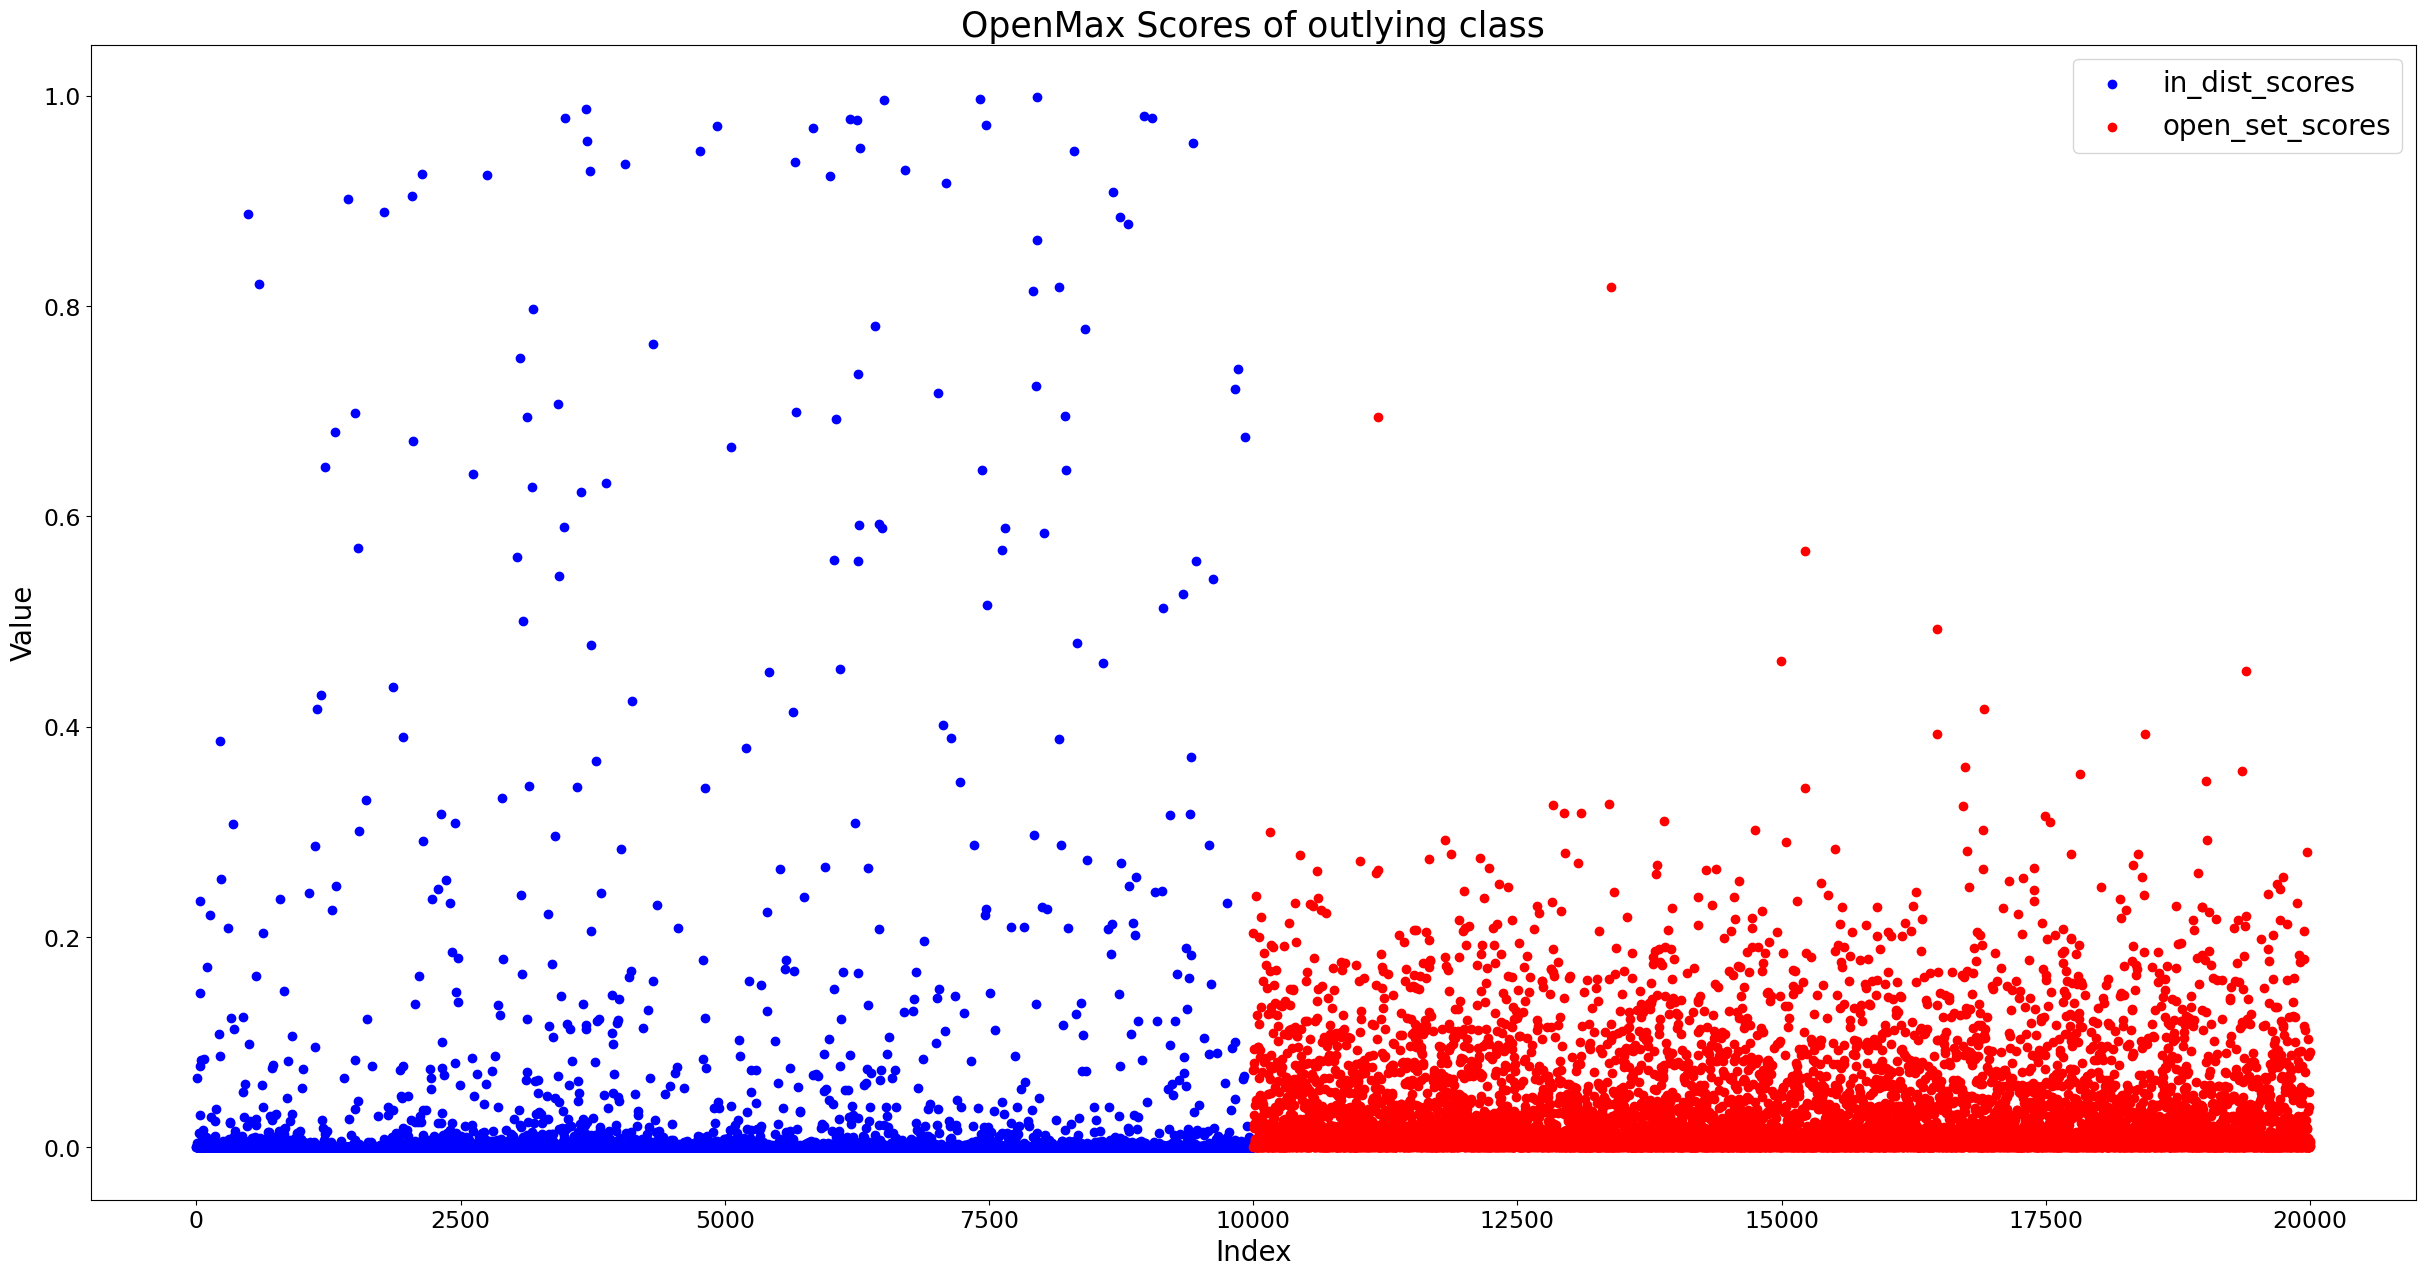

In [18]:
scatter_openmax_scores([om[10] for om in openmax_scores])

## Visualization of Logits

In [19]:
with open(os.path.join('data', 'features', f'avs_test_maxpool.pickle'), 'rb') as f:
    avs_test = pickle.load(f)
with open(os.path.join('data', 'features', f'avs_outlier_maxpool.pickle'), 'rb') as f:
    avs_outlier = pickle.load(f)

In this plot, we show the unnormalized activation vector values for inlying+outlying images. We only plot the most probable class. The color of the datapoint indicates which class the model predicted for the image and the value is the unnormalized logit score. It becomes obvious that the model is simply more confident for inlying datapoints. Thus, it would already be feasable to deploy a simple threshold-based method for outylier detection.

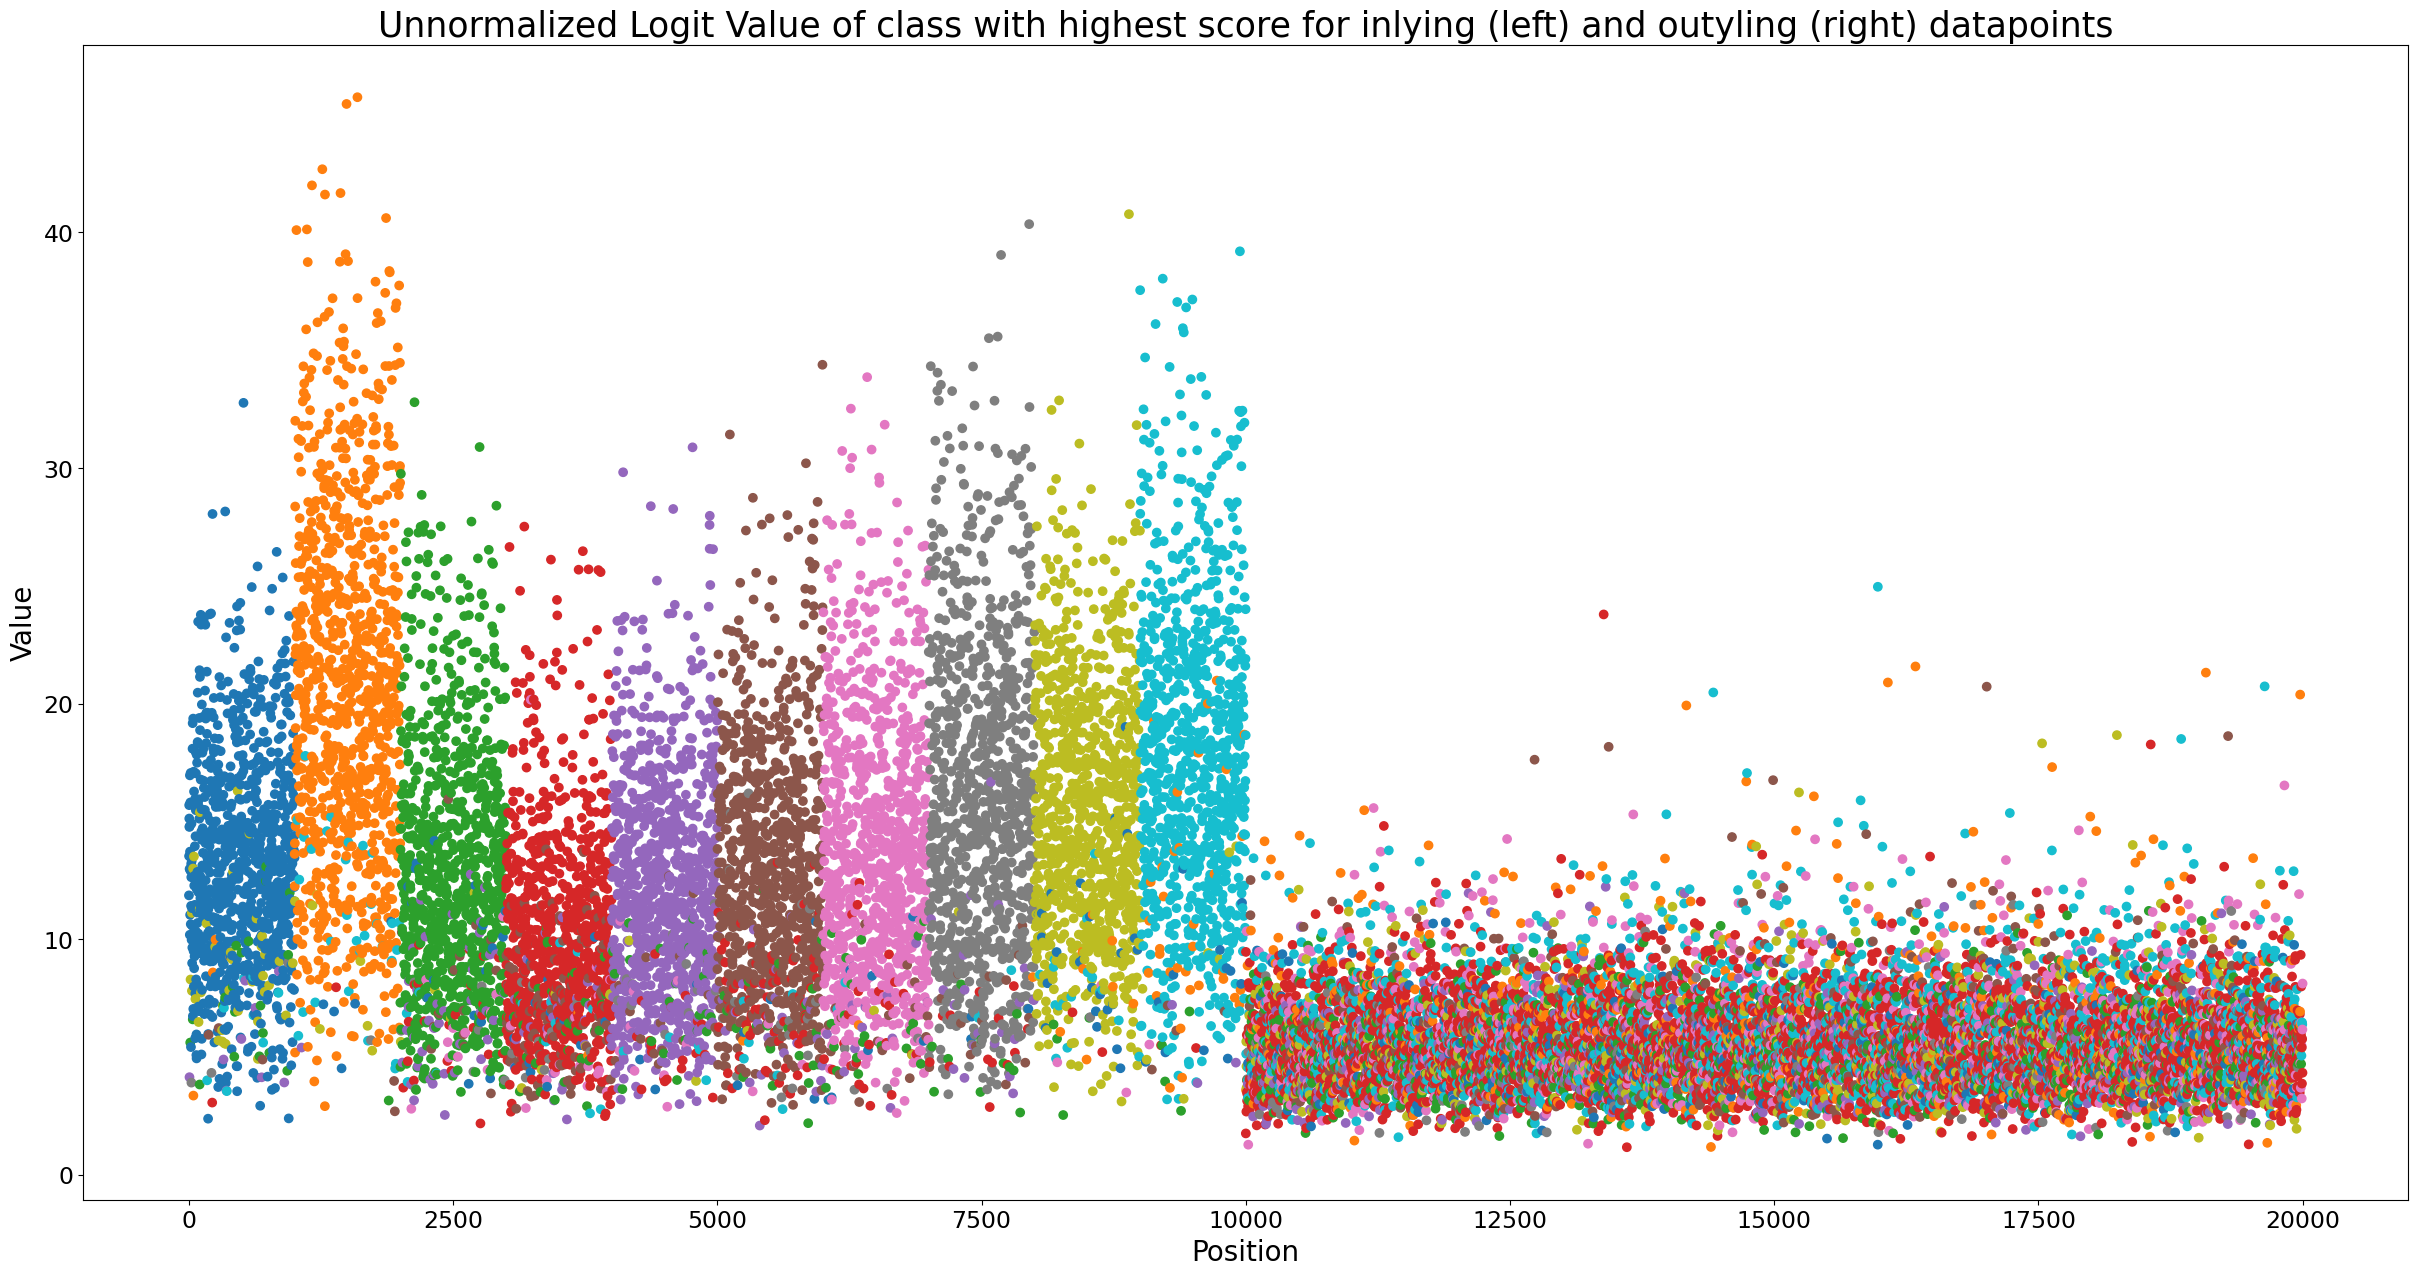

<Figure size 640x480 with 0 Axes>

In [58]:
# Extract the first 10 values from each array (also contains the latent representations)
first_10_values_test = [arr[:10] for arrays in avs_test.values() for arr in arrays]
first_10_values_outlier = [arr[:10] for arrays in avs_outlier.values() for arr in arrays]

# Set up the scatter plot
fig, ax = plt.subplots(figsize=(30, 15))

# Iterate over the arrays and plot the first 10 values
ax.scatter([i for i in range(len(first_10_values_test))], [np.max(arr) for arr in first_10_values_test], c=plt.cm.tab10([np.argmax(arr) for arr in first_10_values_test]))
ax.scatter([i for i in range(len(first_10_values_test), len(first_10_values_test)+len(first_10_values_outlier))], [np.max(arr) for arr in first_10_values_outlier], c=plt.cm.tab10([np.argmax(arr) for arr in first_10_values_outlier]))

# Set plot labels and title
ax.set_xlabel('Position', fontsize=20)
ax.set_ylabel('Value', fontsize=20)
ax.tick_params(axis='y', labelsize=17)
ax.tick_params(axis='x', labelsize=17)
ax.set_title('Unnormalized Logit Value of class with highest score for inlying (left) and outyling (right) datapoints', fontsize=25)

# Display the plot
plt.show()
plt.tight_layout()

Adding to the results presented above, we can have a look which classes the outlying images are (wrongly) classfied as. It can be seen that most outlying datapoints are classfied as class 3, which is also represented by the plot above because class 3 has the lowest logit predictions among all classes.

<BarContainer object of 10 artists>

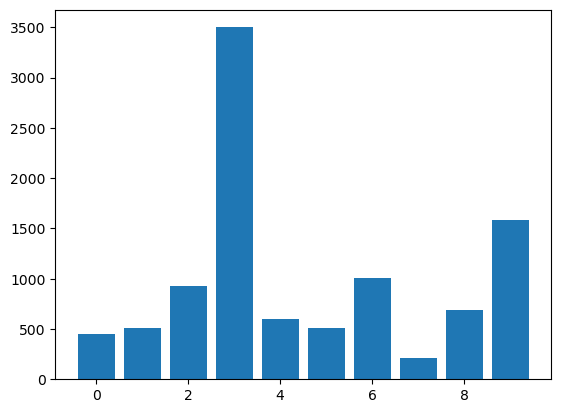

In [23]:
counted = Counter([np.argmax(arr) for arr in first_10_values_outlier])
plt.bar(list(counted.keys()), list(counted.values()))

### Visualization of latent representations

In [28]:
with open(os.path.join('data', 'features', f'avs_train_maxpool.pickle'), 'rb') as f:
    avs_train = pickle.load(f)

mavs = compute_mean_activation_vector(avs_train, 10)

To further analyze what might go wrong, we can have a look at the latent representation of the Mean Activation Vectors (MAV). This plot shows the values of all 105 entries of the MAV of class 7 as an example. 

It can be easily observed, that the latent representation do not add much information as most of them are 0.

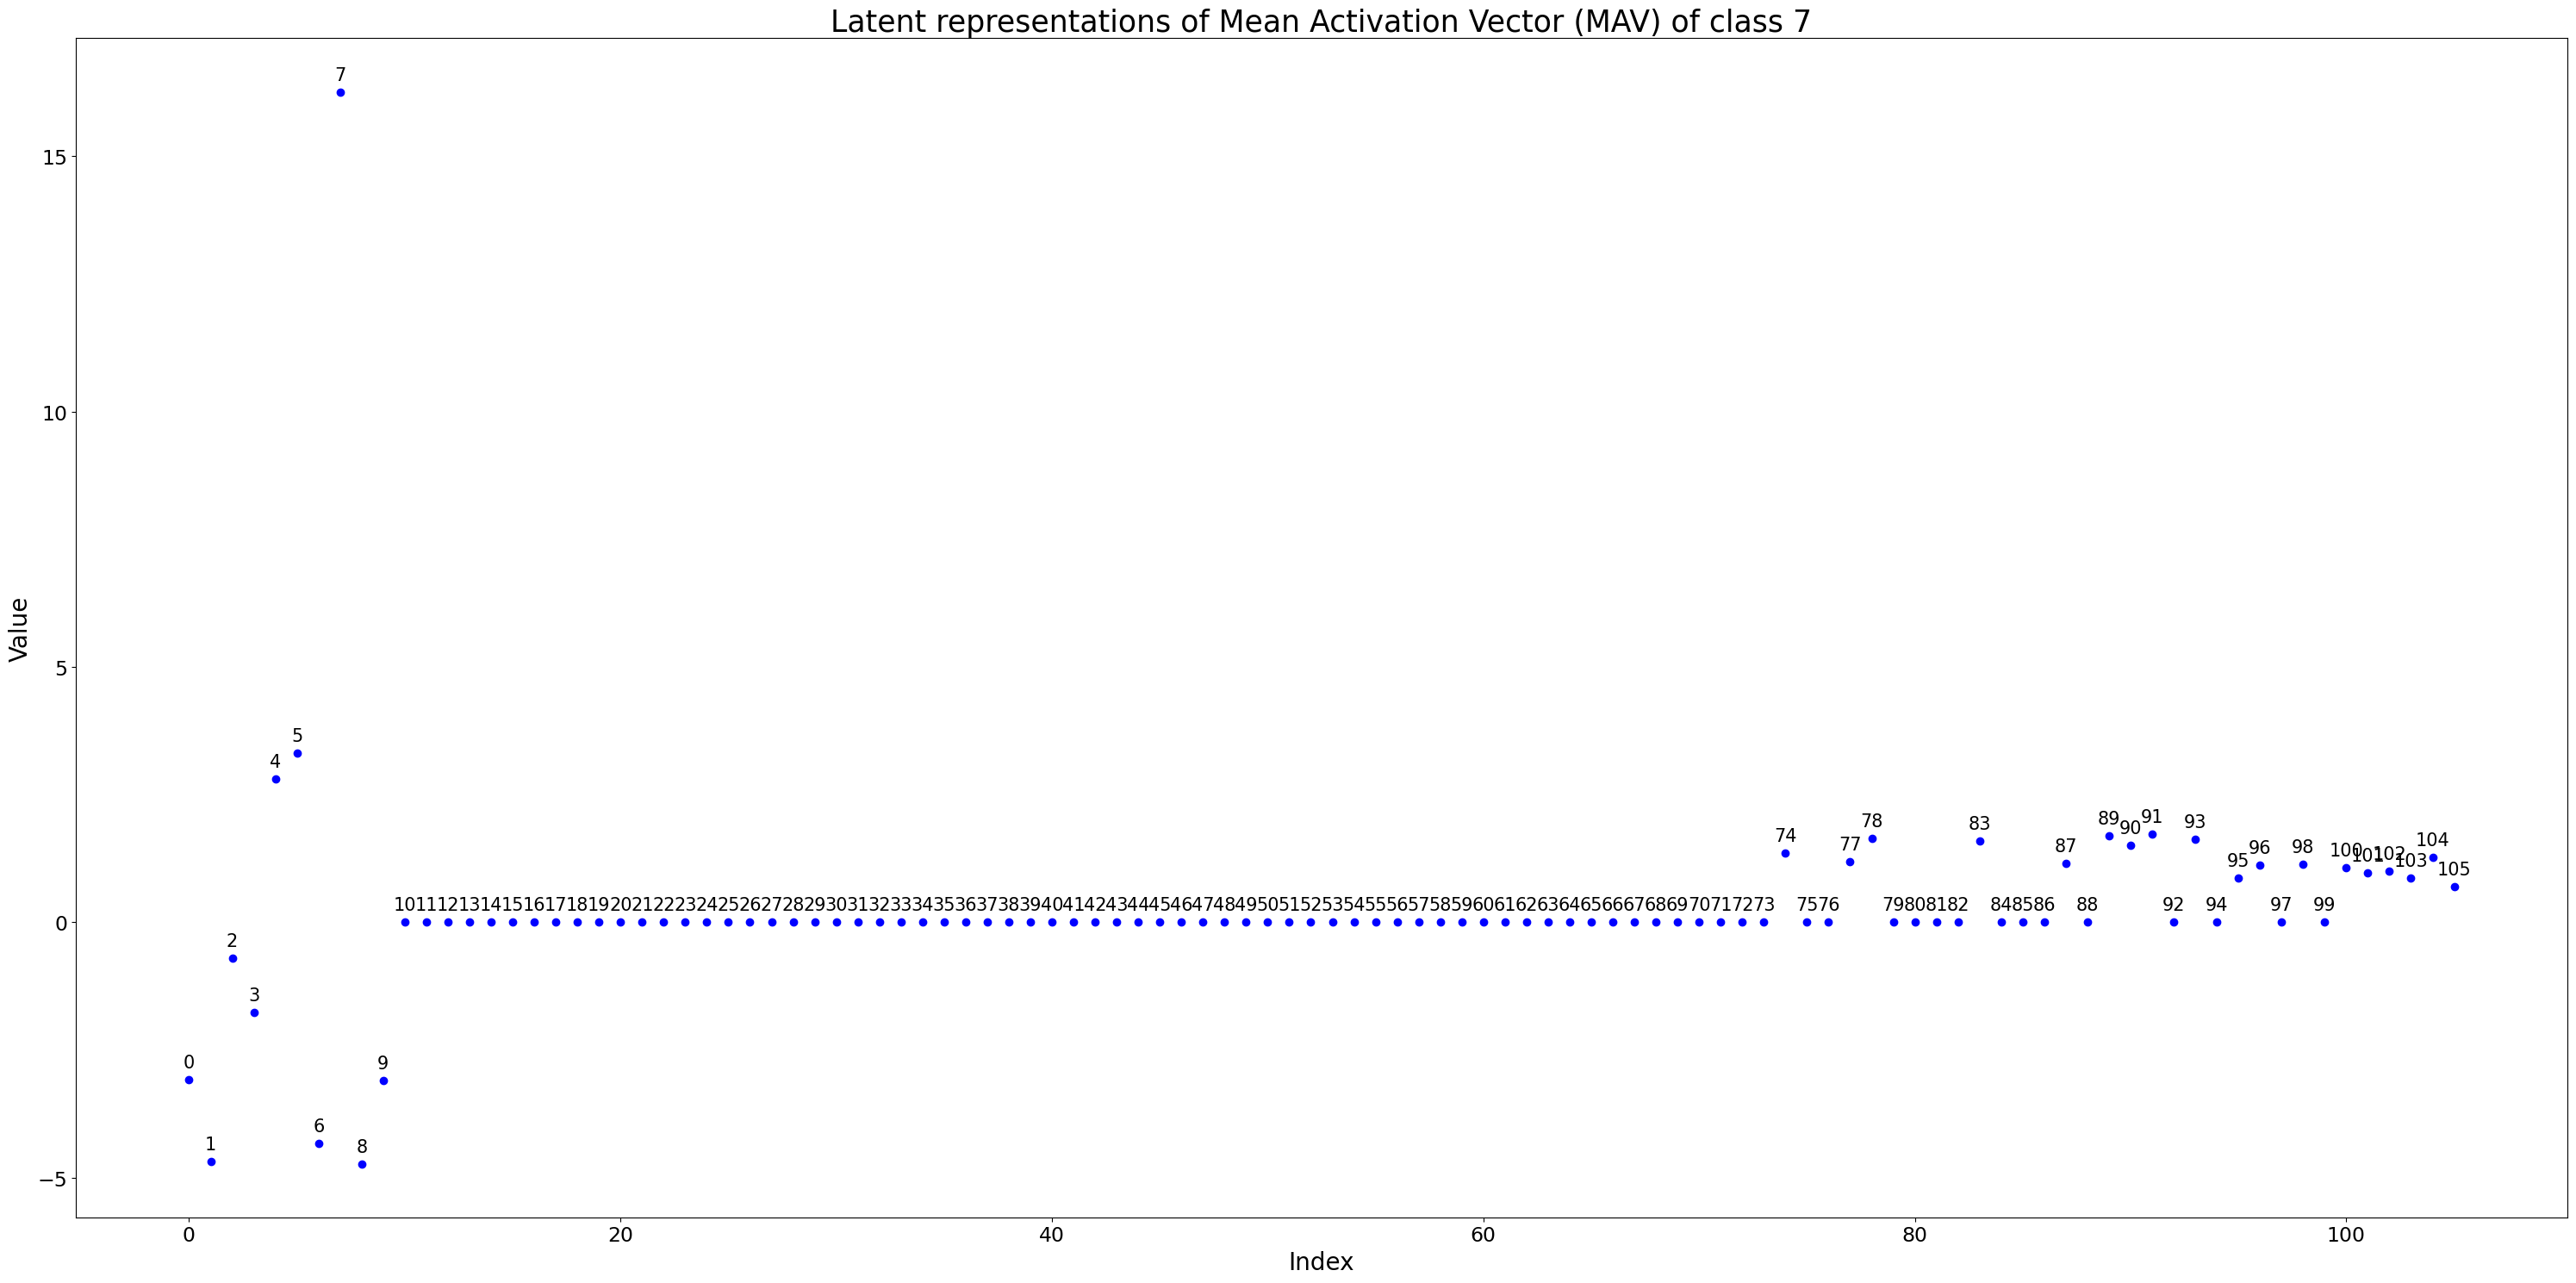

In [62]:
to_plot = mavs[7]

fig, ax = plt.subplots(figsize=(30, 15))
ax.scatter(range(len(to_plot)), to_plot, color='blue')
ax.set_xlabel('Index', fontsize=20)
ax.set_ylabel('Value', fontsize=20)
ax.tick_params(axis='y', labelsize=17)
ax.tick_params(axis='x', labelsize=17)
ax.set_title(f'Latent representations of Mean Activation Vector (MAV) of class 7', fontsize=25)
# Add labels to each point
for i, (x, y) in enumerate(zip(range(len(to_plot)), to_plot)):
    ax.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join('data', 'plots', 'mav_class_7'))

### Visualizations of W-Scores

In [54]:
with open(os.path.join('data', 'plot_pickles', f'w_scores_maxpool_100_softmax_before.pickle'), 'rb') as f:
    w_scores = pickle.load(f)

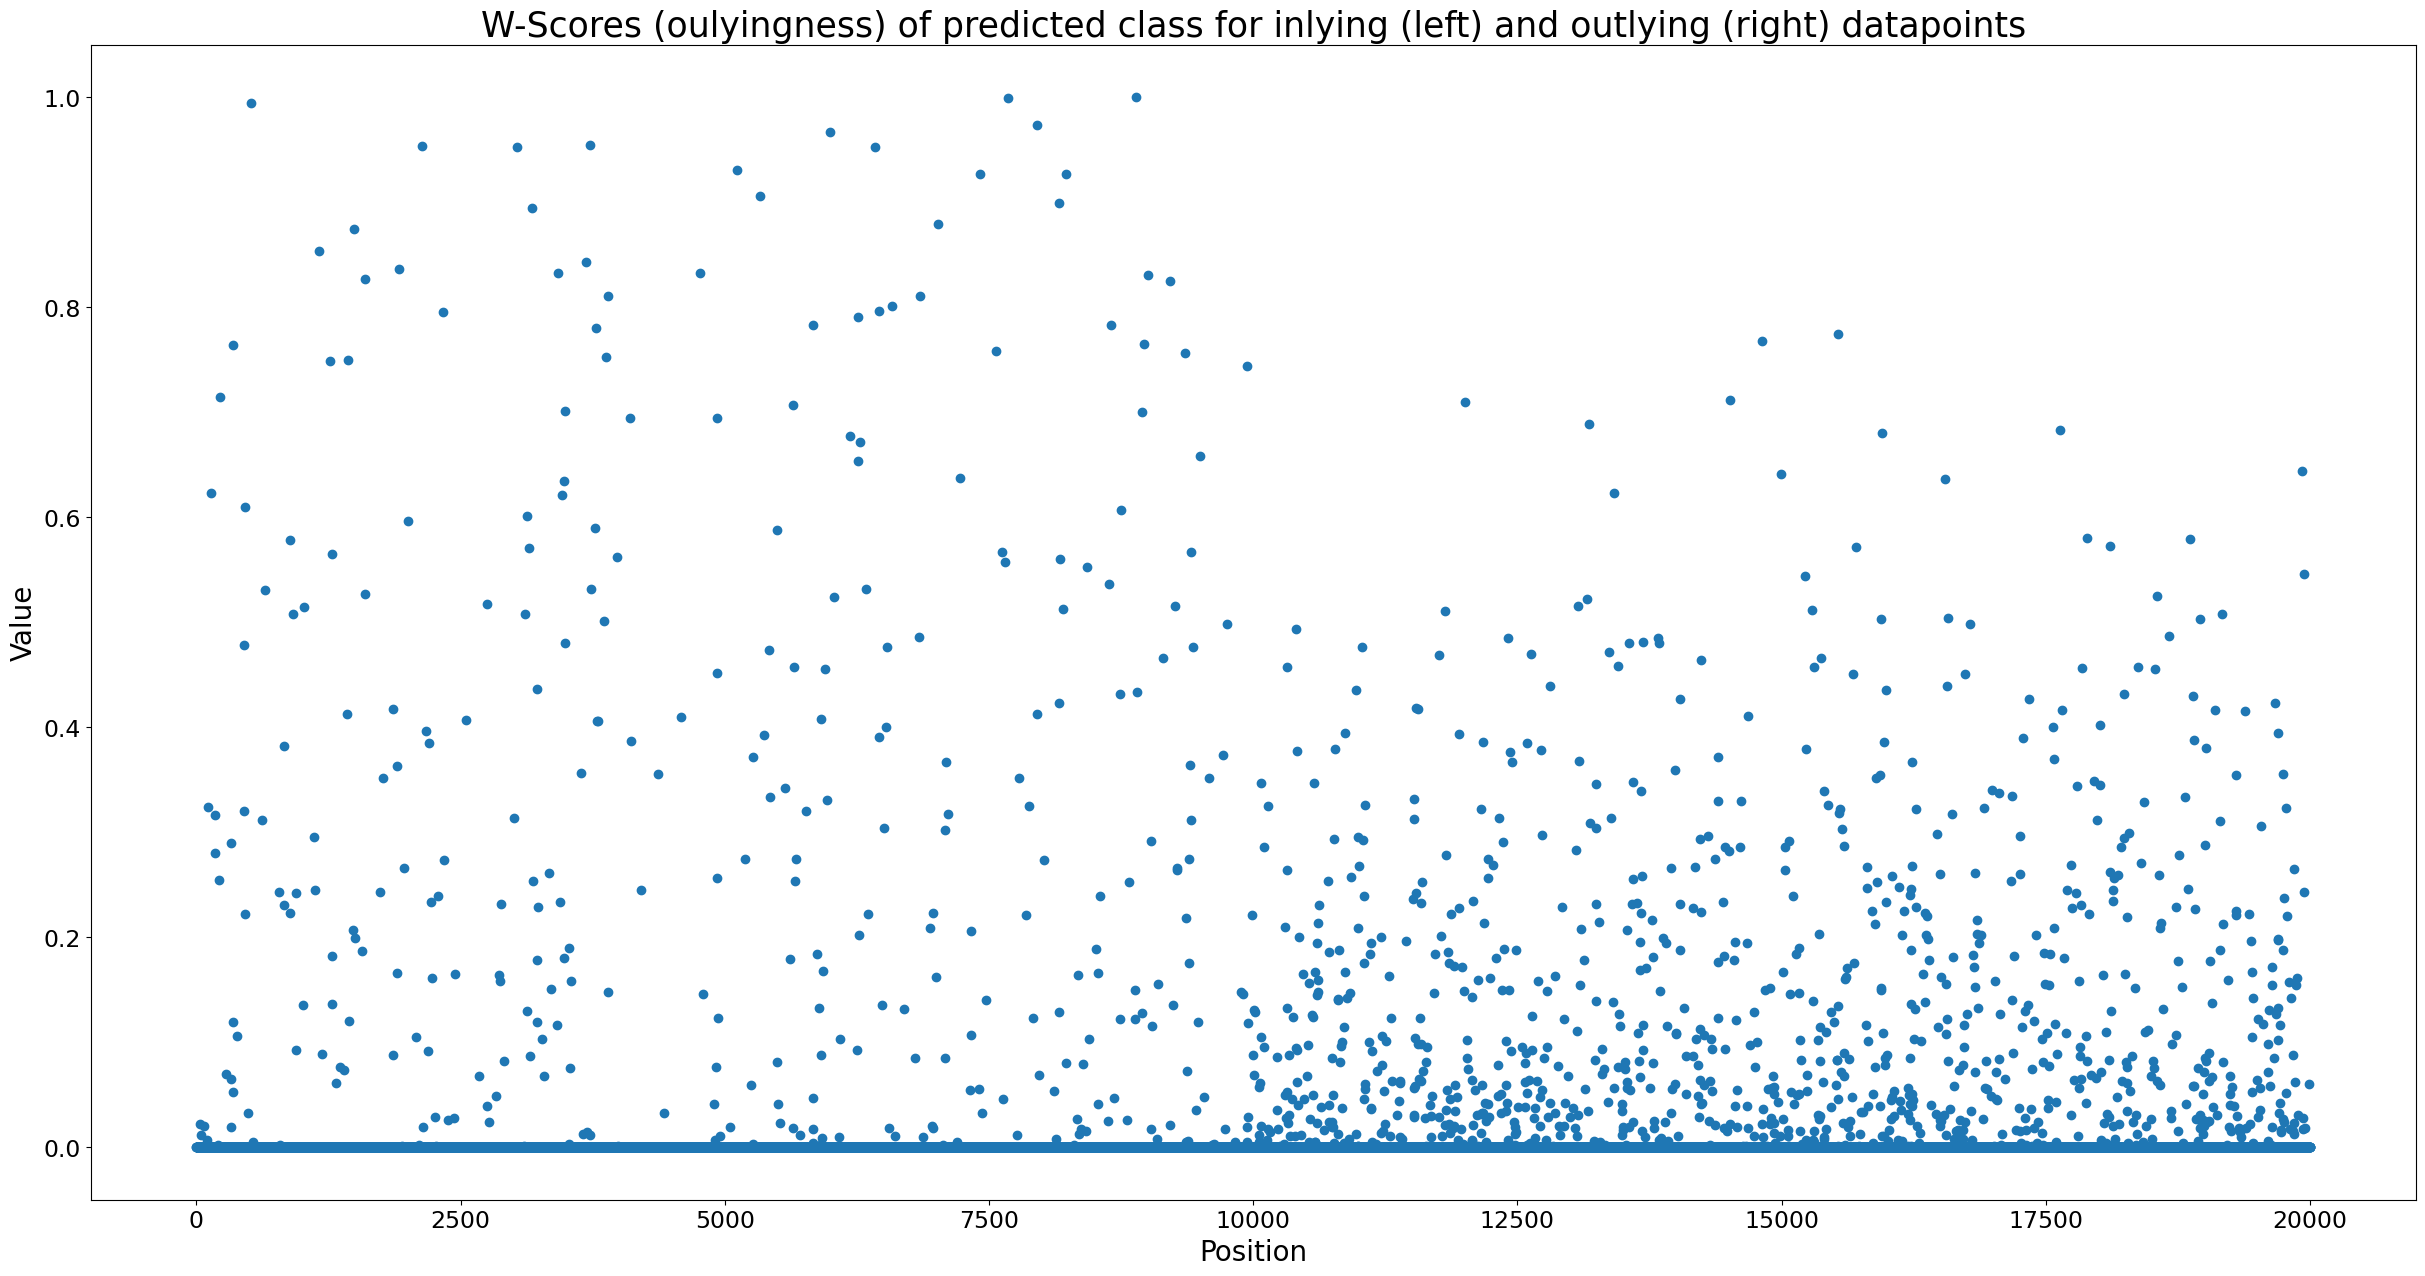

<Figure size 640x480 with 0 Axes>

In [60]:
# Set up the scatter plot
fig, ax = plt.subplots(figsize=(30, 15))

# Iterate over the arrays and plot the first 10 values
ax.scatter(range(len(w_scores)), [tpl[0][np.argmax(tpl[1])] for tpl in w_scores])

# Set plot labels and title
ax.set_xlabel('Position', fontsize=20)
ax.set_ylabel('Value', fontsize=20)
ax.tick_params(axis='y', labelsize=17)
ax.tick_params(axis='x', labelsize=17)
ax.set_title('W-Scores (oulyingness) of predicted class for inlying (left) and outlying (right) datapoints', fontsize=25)

# Display the plot
plt.show()
plt.tight_layout()